In [121]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score

In [122]:
# print(sales_train.info())
# print(item_categories.info())
# print(items.info())
# print(shops.info())
# print(sales_train.describe())
# print(item_categories["item_category_id"].sample(5))
# print(items["item_id"].sample(5))
# print(shops["shop_name"].sample(5))
# print(sales_train["shop_id"].value_counts())

In [123]:
def add_hierarchical_features(sales_train, item_categories, items, shops):
    le = LabelEncoder()
    item_categories.item_category_name = item_categories.item_category_name.str.split(" ").str[0]
    item_categories['item_category_label'] = le.fit_transform(item_categories['item_category_name'])
        
    shops.shop_name = shops.shop_name.str.split(" ").str[0]
    shops['location_label'] = le.fit_transform(shops['shop_name'])                
    
    sales_train = pd.merge(sales_train, items, left_on='item_id', right_on='item_id')
    sales_train = pd.merge(sales_train, shops, left_on='shop_id', right_on='shop_id')
    sales_train = pd.merge(sales_train, item_categories, left_on='item_category_id', right_on='item_category_id')
    sales_train.drop(['shop_name', 'item_category_name', 'item_name', 'item_category_id'], axis=1, inplace=True)
    print(sales_train.sample(4))
    
#     df = pd.merge(df, items, left_on='item_id', right_on='item_id', how='left').drop(['item_name'], axis=1)
    return sales_train
    

In [124]:
sales_train = pd.read_csv('./data/sales_train.csv')
item_categories = pd.read_csv('./data/item_categories.csv')
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
sales_test = pd.read_csv('./data/test.csv')
sales_test.drop('ID', inplace=True, axis=1)
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id == 0, 'shop_id'] = 57

#Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
sales_test.loc[sales_test.shop_id == 10, 'shop_id'] = 11

# outlier = sales_train.loc[sales_train['item_price'] > 100000]
# print(items[items['item_id'].isin(outlier["item_id"])])
# outlier = sales_train.loc[sales_train['item_cnt_day'] > 900]
# print(items[items['item_id'].isin(outlier["item_id"])])

sales_train = sales_train[sales_train.item_price > 0]
sales_train = sales_train[sales_train.item_price < 100000]
sales_train = sales_train[(sales_train.item_cnt_day < 1000) & (sales_train.item_cnt_day >= 0)]
# sales_train['item_cnt_day'] = np.log1p(sales_train['item_cnt_day'])
# sales_train['item_price'] = np.log1p(sales_train['item_price'])
sales_train = add_hierarchical_features(sales_train, item_categories, items, shops)
sales_train['month_number'] = sales_train['date_block_num'].apply(lambda x: x % 12 + 1)
sales_train.drop('date', inplace=True, axis=1)




               date  date_block_num  shop_id  item_id  item_price  item_cnt_day  location_label  item_category_label
1878881  05.02.2013               1       52    19811       349.0           1.0              26                    7
2396326  25.08.2013               7       54    11424       449.0           1.0              27                    8
921229   18.04.2014              15       25     2808       999.0           1.0              14                    5
1914141  17.03.2015              26       53     8624       149.0           1.0              26                    7


In [125]:
df = pd.read_csv('./data/sales_train_test.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.fillna(0)
print(df.shape)

(14456188, 8)


In [126]:
df

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,location_label,item_category_label,month_number
0,2.0,27.0,0,1.0,2499.0,1,5,1
1,2.0,27.0,1,0.0,0.0,1,5,2
2,2.0,27.0,2,0.0,0.0,1,5,3
3,2.0,27.0,3,0.0,0.0,1,5,4
4,2.0,27.0,4,0.0,0.0,1,5,5
...,...,...,...,...,...,...,...,...
14456183,45.0,342.0,34,0.0,0.0,21,8,11
14456184,45.0,254.0,34,0.0,0.0,21,8,11
14456185,45.0,204.0,34,0.0,0.0,21,8,11
14456186,45.0,180.0,34,0.0,0.0,21,8,11


In [127]:
# gb = ['date_block_num', 'shop_id', 'item_id', 'location_label', 'item_category_label']
# df = sales_train.groupby(gb).agg(item_cnt_month=('item_cnt_day', 'sum'), item_price_month=('item_price', 'mean')).reset_index()
# print(df.shape)

In [128]:
# from itertools import product
# matrix=[]
# for i in range(34):
#     sales = sales_train[sales_train.date_block_num==i]
#     matrix.append(np.array(list(product([i], sales_train.shop_id.unique(), sales_train.item_id.unique())), dtype='int16'))

# cols = ['date_block_num','shop_id','item_id']
# matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

In [129]:
# group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
# group.columns = ['item_cnt_month']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=cols, how='left')
# matrix['item_cnt_month'] = (matrix['item_cnt_month']
#                                 .fillna(0)
#                                 .clip(0,20))

In [130]:
df['month'] = df.date_block_num % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
df['days'] = df['month'].map(days).astype(np.int8)

cache = {}
df['item_shop_last_sale'] = -1
for idx, row in df.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        df.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num      
        
cache = {}
df['item_last_sale'] = -1
for idx, row in df.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            df.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num   

            
df['item_shop_first_sale'] = df['date_block_num'] - df.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
df['item_first_sale'] = df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')
df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)
# sales_train_zero = df.sort_values(['shop_id', 'item_id', 'date_block_num'],ascending=[True, True, True]).reset_index()
# # sales_train_zero['month_number'] = sales_train_zero['date_block_num']
# sales_train_pivot = pd.pivot(
#     data=sales_train_zero,
#     index=['shop_id', 'item_id'],    # Column to use to make new frame’s index. If None, uses existing index.
#     columns='date_block_num',  # Column to use to make new frame’s columns.
#     values='item_cnt_month'    # Column(s) to use for populating new frame’s values.
# )
# sales_train_pivot.reset_index(inplace=True)
# sales_train_pivot = sales_train_pivot.T.fillna(value=0, axis=0).T
# sales_train_melt = sales_train_pivot.melt(id_vars=['shop_id', 'item_id'], value_vars=list(np.arange(34)), value_name='item_cnt_month')
# print(sales_train_melt.shape)
# sales_train_melt = pd.merge(sales_train_melt, df[['date_block_num','shop_id', 'item_id','item_price_month']], on=['date_block_num','shop_id','item_id'], how='left')#, 'location_label', 'item_category_label'
# print(sales_train_melt.shape)
# sales_train_melt=add_hierarchical_features(sales_train_melt, item_categories, items, shops)
# print(sales_train_melt.shape)
# sales_train_melt['month_number'] = sales_train_melt['date_block_num'].apply(lambda x: x % 12 + 1)

# sales_test = add_hierarchical_features(sales_test, item_categories, items, shops)
# sales_test['date_block_num'] = 34
# sales_test['month_number'] = sales_test['date_block_num'].apply(lambda x: x % 12 + 1)
# sales_test['item_cnt_month'] = np.nan
# sales_test['item_price_month'] = np.nan
# sales_train_test = pd.concat([sales_train_melt, sales_test])
# sales_train_test.to_csv('./data/sales_train_test.csv')




In [131]:
# sales_train[(sales_train.shop_id == 25) & (sales_train.item_id == 4249)]

In [132]:
df[(df.shop_id == 27) & (df.item_id == 4249)]

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,location_label,item_category_label,month_number,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
6490328,27.0,4249.0,0,6.0,1899.000000,14,5,1,0,31,-1,-1,0,0
6490329,27.0,4249.0,1,9.0,1599.000000,14,5,2,1,28,1,-1,1,1
6490330,27.0,4249.0,2,20.0,1305.791429,14,5,3,2,31,1,-1,2,2
6490331,27.0,4249.0,3,7.0,1599.000000,14,5,4,3,30,1,-1,3,3
6490332,27.0,4249.0,4,3.0,1599.000000,14,5,5,4,31,1,-1,4,4
6490333,27.0,4249.0,5,0.0,0.000000,14,5,6,5,30,1,-1,5,5
6490334,27.0,4249.0,6,6.0,1399.062500,14,5,7,6,31,1,-1,6,6
6490335,27.0,4249.0,7,10.0,1376.916667,14,5,8,7,31,1,-1,7,7
6490336,27.0,4249.0,8,3.0,1199.000000,14,5,9,8,30,1,-1,8,8
6490337,27.0,4249.0,9,11.0,879.066667,14,5,10,9,31,1,-1,9,9


In [133]:
df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)

def make_lags(df, col, lags, gb, drop):
    for i in lags:
        df[col+"_lag_{}".format(i)] = df.groupby(gb)[col].shift(i)
    df.drop(col, inplace=drop, axis=1)
    return df

# def make_init_features(df, dataset, gb):
#     tmp = dataset.groupby(gb).agg(
#                           item_cnt_month_mean=('item_cnt_day', 'mean'), 
#                           item_price_month_mean=('item_price', 'mean')
#                           ).reset_index()   
#     df = pd.merge(df, tmp, on = gb, how = 'left')    
#     df['month_number'] = df['date_block_num'].apply(lambda x: x % 12 + 1)
#     return df

def make_location_features(df, dataset, gb):
    tmp = dataset.groupby(gb).agg(loc_item_cnt_mean=('item_cnt_day', 'mean')).reset_index()    
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    tmp = dataset.groupby(gb).agg(loc_price_mean=('item_price', 'mean')).reset_index()
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    return df

gb = ['date_block_num', 'item_id', 'location_label']
df = make_location_features(df, sales_train, gb)  
df = make_lags(df, 'loc_item_cnt_mean', [1,2,3,6,12],  gb, True)
# df = make_lags(df, 'loc_price_mean', [1],  gb, True)
print(df.shape)

def make_item_categorial_features(df, dataset, gb):
    tmp = dataset.groupby(gb).agg(item_cat_cnt_mean=('item_cnt_day', 'mean')).reset_index()    
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    tmp = dataset.groupby(gb).agg(item_cat_price_mean=('item_price', 'mean')).reset_index()        
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    return df

gb = ['date_block_num', 'item_id', 'item_category_label']
df = make_item_categorial_features(df, sales_train, gb)  
df = make_lags(df, 'item_cat_cnt_mean', [1,2,3,6,12],  gb, True)
# df = make_lags(df, 'item_cat_price_mean', [1],  gb, True)
print(df.shape)

def make_shop_categorial_features(df, dataset, gb):
    tmp = dataset.groupby(gb).agg(shop_cat_cnt_mean=('item_cnt_day', 'mean')).reset_index()     
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    tmp = dataset.groupby(gb).agg(shop_cat_price_mean=('item_price', 'mean')).reset_index()    
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    return df

gb = ['date_block_num', 'shop_id', 'item_category_label']
df = make_shop_categorial_features(df, sales_train, gb)  
df = make_lags(df, 'shop_cat_cnt_mean', [1,2,3,6,12],  gb, True)
# df = make_lags(df, 'shop_cat_price_mean', [1],  gb, True)
print(df.shape)


def make_shop_features(df, dataset, gb):
    tmp = dataset.groupby(gb).agg(shop_cnt_mean=('item_cnt_day', 'mean')).reset_index()         
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    tmp = dataset.groupby(gb).agg(shop_price_mean=('item_price', 'mean')).reset_index()    
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    return df

gb = ['date_block_num', 'shop_id']
df = make_shop_features(df, sales_train, gb)  
df = make_lags(df, 'shop_cnt_mean', [1,2,3,6,12],  gb, True)
# df = make_lags(df, 'shop_price_mean', [1],  gb, True)
print(df.shape)

# def make_month_features(df, dataset, gb):
#     tmp = dataset.groupby(gb).agg(
#                           cnt_month_mean=('item_cnt_day', 'mean')).reset_index()     
# #                           price_month_mean=('item_price', 'mean')).reset_index()    
#     df = pd.merge(df, tmp, on = gb, how = 'left')    
#     return df

# gb = ['date_block_num', 'shop_id', 'item_id', 'location_label', 'item_category_label']
# df = make_init_features(df, sales_train, gb)   
# df.item_cnt_month = df.item_cnt_month.clip(0,20)
# print(df.shape)

def make_categorial_features(df, dataset, gb):
    tmp = dataset.groupby(gb).agg(cat_cnt_mean=('item_cnt_day', 'mean')).reset_index()    
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    tmp = dataset.groupby(gb).agg(cat_price_mean=('item_price', 'mean')).reset_index()        
    df = pd.merge(df, tmp, on = gb, how = 'left')    
    return df

gb = ['date_block_num', 'item_category_label']
df = make_categorial_features(df, sales_train, gb)  
df = make_lags(df, 'cat_cnt_mean', [1],  gb, True)
# df = make_lags(df, 'cat_price_mean', [1],  gb, True)
print(df.shape)


df = make_lags(df, 'item_cnt_month', [1,2,3,6,12], ['shop_id', 'item_id'], False)
# df = make_lags(df, 'item_price_month', [1,2,3,6,12], ['shop_id', 'item_id'], False)
for i in [1]:
    df['item_cnt_month'+"_lag_{}".format(i)+"_diff"] = df['item_cnt_month'+"_lag_{}".format(i)].diff()#.clip(0,20)

# df = make_lags(df, 'item_price_month', [1,6,12], ['shop_id', 'item_id'], False)
# df.drop('item_price_month', inplace=True, axis=1)
print(df.shape)

# def make_price_change(df, dataset, gb):    
#     tmp = df.groupby(gb).agg(price_change=('item_price', 'diff')).reset_index()     
#     df = pd.merge(df, tmp, on = gb, how = 'left')  

# gb = ['item_id', 'shop_id']
# df = make_price_change(df, df, gb)

# def make_month_since_last_sell(df, dataset, gb):    
#     tmp = df.groupby(gb).agg(month_since_last_sell=('date_block_num', 'diff')).reset_index()     
#     df = pd.merge(df, tmp, on = gb, how = 'left')  

# gb = ['date_block_num', 'item_id', 'shop_id']
# df = make_price_change(df, sales_train, gb)




# gb = ['date_block_num', 'shop_id', 'location_label']
# df = make_month_features(df, dataset, gb)  
# df = make_lags(df, 'cnt_month_mean', [1],  gb, True)
# df = make_lags(df, 'price_month_mean', [1],  gb, True)
# print(df.shape)







(14456188, 20)
(14456188, 26)
(14456188, 32)
(14456188, 38)
(14456188, 40)
(14456188, 46)


In [134]:
df = df.fillna(0)
df = df.sort_values(['shop_id', 'item_id', 'date_block_num'],ascending=[True, True, True]).reset_index(drop=True)

In [135]:
# df = df.drop('item_price_month', axis=1)
df = df[df['date_block_num'] >= 12]
print(df.shape)

(9429604, 46)


In [136]:
# df.to_csv('./data/df.csv')

In [137]:


# df_g['item_cnt_month_std'].fillna(0, inplace=True)
# df_g['item_price_month_std'].fillna(0, inplace=True)
# df_g['revenue_mean'].fillna(0, inplace=True)
# df_g['loc_cnt_month_std'].fillna(0, inplace=True)
# df_g['loc_price_month_std'].fillna(0, inplace=True)
# df_g['cat_cnt_month_std'].fillna(0, inplace=True)
# df_g['cat_price_month_std'].fillna(0, inplace=True)
# df_g['price_month_std'].fillna(0, inplace=True)
# df_g['cnt_month_std'].fillna(0, inplace=True)
# df_g['loc_cat_cnt_month_std'].fillna(0, inplace=True)
# df_g['loc_cat_price_month_std'].fillna(0, inplace=True)


In [138]:
# df_g.item_cnt_day_min = df_g.item_cnt_day_min.clip(0,20)
# df_g.item_cnt_day_max = df_g.item_cnt_day_max.clip(0,20)
# df_g.item_price_min = df_g.item_price_min.clip(0,10000)
# df_g.item_price_max = df_g.item_price_max.clip(0,10000)

In [139]:
# fig0, ax0 = plt.subplots(3, figsize=(16,10))
# ax0[0].hist(sales_train.item_price, bins=100, log=True)
# ax0[0].set(xlabel = "Item Price",
#            ylabel = "Number of Items")
# ax0[1].hist(sales_train.item_cnt_day, bins=100, log=True)
# ax0[1].set(xlabel = "Items sold",
#            ylabel = "Number of Items sold")
# ax0[2].hist(sales_train.item_id, bins=100, log=False)
# ax0[2].set(xlabel = "Item Id",
#            ylabel = "Number of Items")

# fig1, ax1 = plt.subplots(3,figsize=(16,10))
# monthly_sales = sales_train.groupby(['date_block_num']).sum().reset_index()
# sns.barplot(ax=ax1[0], x=monthly_sales.date_block_num, y=monthly_sales.item_cnt_day)
# ax1[0].set(xlabel = "Month number",
#            ylabel = "Number of Sales")

# shop_sales = sales_train.groupby(['shop_id']).sum().reset_index()
# sns.barplot(ax=ax1[1], x=shop_sales.shop_id, y=shop_sales.item_cnt_day)
# ax1[1].set(xlabel = "Shop id",
#            ylabel = "Number of Sales")

# mean_sales = sales_train.groupby(['date_block_num'])['item_cnt_day'].mean().reset_index()
# sns.barplot(ax=ax1[2], x=mean_sales.date_block_num, y=mean_sales.item_cnt_day)
# ax1[2].set(xlabel = "Month number",
#            ylabel = "Mean Number of Sales")
# sns.despine()

# fig2, ax2 = plt.subplots(2,figsize=(16,10))
# monthly_shops = sales_train.groupby(['date_block_num','shop_id']).count().reset_index()
# sns.barplot(ax=ax2[0], x=monthly_shops.date_block_num, y=monthly_shops.shop_id)
# ax2[0].set(xlabel = "Month number",
#            ylabel = "Number of Shops")

# shop_sales = sales_train.groupby(['date_block_num','item_id']).count().reset_index()
# sns.barplot(ax=ax2[1], x=shop_sales.date_block_num, y=shop_sales.item_id)
# ax2[1].set(xlabel = "Month number",
#            ylabel = "Number of Items")

# fig3, ax3 = plt.subplots(1,figsize=(16,10))
# positive_sales_train = sales_train[sales_train['item_cnt_day'] >= 0]
# monthly_sales = positive_sales_train.groupby(['shop_id','date_block_num']).sum().reset_index()
# for i in  range(0,34):
#     sns.lineplot(ax=ax3, x=monthly_sales[monthly_sales.shop_id == i].date_block_num, y=monthly_sales[monthly_sales.shop_id == i].item_cnt_day)
# ax3.set(xlabel = "Month number",
#         ylabel = "Number of Sales per Shop")
# sns.despine()

# # fig3, ax3 = plt.subplots(1,figsize=(16,10))
# # positive_sales_train = sales_train[sales_train['item_cnt_day'] >= 0]
# # monthly_sales = positive_sales_train.groupby(['shop_id','date_block_num']).sum().reset_index()
# # for i in  range(0,34):
# #     sns.lineplot(ax=ax3, x=monthly_sales[monthly_sales.shop_id == i].date_block_num, y=monthly_sales[monthly_sales.shop_id == i].item_cnt_day)
# # ax3.set(xlabel = "Month number",
# #         ylabel = "Number of Sales per Shop")
# # sns.despine()

# # df.sample(10).iloc[[2]].to_numpy()
# # df.sample(10).item_cnt_day.iloc[[2]].to_numpy()

# # fig5, ax5 = plt.subplots(1,figsize=(16,10))
# # for index, row in  df_sample.iterrows():
# #     sns.lineplot(ax=ax5, x=row.item_cnt_day.index, y=row.item_cnt_day.diff().to_numpy())
# # ax5.set(xlabel = "Month number",
# #         ylabel = "Diff Number of Sales per Shop")
# sns.despine()

# plt.show()

In [140]:
df.item_cnt_month_lag_1_diff.min()

-20.0

In [141]:
df[(df.shop_id==14) & (df.item_id==3676)]

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,location_label,item_category_label,month_number,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,loc_price_mean,loc_item_cnt_mean_lag_1,loc_item_cnt_mean_lag_2,loc_item_cnt_mean_lag_3,loc_item_cnt_mean_lag_6,loc_item_cnt_mean_lag_12,item_cat_price_mean,item_cat_cnt_mean_lag_1,item_cat_cnt_mean_lag_2,item_cat_cnt_mean_lag_3,item_cat_cnt_mean_lag_6,item_cat_cnt_mean_lag_12,shop_cat_price_mean,shop_cat_cnt_mean_lag_1,shop_cat_cnt_mean_lag_2,shop_cat_cnt_mean_lag_3,shop_cat_cnt_mean_lag_6,shop_cat_cnt_mean_lag_12,shop_price_mean,shop_cnt_mean_lag_1,shop_cnt_mean_lag_2,shop_cnt_mean_lag_3,shop_cnt_mean_lag_6,shop_cnt_mean_lag_12,cat_price_mean,cat_cnt_mean_lag_1,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_lag_1_diff
2330795,14.0,3676.0,12,1.0,899.000,9,5,1,0,31,1,-1,12,12,899.000,0.0,0.0,0.0,0.0,0.0,895.256164,1.123288,1.123288,1.123288,1.123288,0.0,1024.103482,1.347744,1.347744,1.347744,1.347744,1.347744,1023.622052,1.274179,1.274179,1.274179,1.274179,1.274179,1010.209758,1.162329,1.0,2.0,3.0,0.0,1.0,-1.0
2330796,14.0,3676.0,13,1.0,899.000,9,5,2,1,28,1,-1,13,13,899.000,0.0,0.0,0.0,0.0,0.0,893.191489,1.021277,1.021277,1.021277,1.021277,0.0,924.351989,1.589454,1.589454,1.589454,1.589454,1.589454,1005.243139,1.442940,1.442940,1.442940,1.442940,1.442940,948.048592,1.221746,1.0,1.0,2.0,0.0,0.0,0.0
2330797,14.0,3676.0,14,4.0,630.295,9,5,3,2,31,1,-1,14,14,630.295,0.0,0.0,0.0,0.0,0.0,667.371193,1.159091,1.159091,1.159091,1.159091,0.0,1249.541158,1.272031,1.272031,1.272031,1.272031,1.272031,1215.306768,1.251256,1.251256,1.251256,1.251256,1.251256,1161.173326,1.277230,1.0,1.0,1.0,0.0,0.0,0.0
2330798,14.0,3676.0,15,4.0,555.395,9,5,4,3,30,1,-1,15,15,569.516,0.0,0.0,0.0,0.0,0.0,548.603502,1.101449,1.101449,1.101449,1.101449,0.0,1241.063581,1.381818,1.381818,1.381818,1.381818,1.381818,1129.996768,1.266667,1.266667,1.266667,1.266667,1.266667,1097.211006,1.288353,4.0,1.0,1.0,3.0,0.0,3.0
2330799,14.0,3676.0,16,0.0,0.000,9,5,5,4,31,1,-1,16,16,0.000,0.0,0.0,0.0,0.0,0.0,632.374074,1.037037,1.037037,1.037037,1.037037,0.0,1133.107470,1.777512,1.777512,1.777512,1.777512,1.777512,1007.312914,1.462838,1.462838,1.462838,1.462838,1.462838,1087.023954,1.389007,4.0,4.0,1.0,2.0,0.0,0.0
2330800,14.0,3676.0,17,3.0,629.100,9,5,6,5,30,1,-1,17,17,629.100,0.0,0.0,0.0,0.0,0.0,629.048214,1.035714,1.035714,1.035714,1.035714,0.0,1126.286267,1.280702,1.280702,1.280702,1.280702,1.280702,939.015689,1.259378,1.259378,1.259378,1.259378,1.259378,1092.065181,1.198365,0.0,4.0,4.0,1.0,0.0,-4.0
2330801,14.0,3676.0,18,1.0,629.000,9,5,7,6,31,1,-1,18,18,627.500,0.0,0.0,0.0,0.0,0.0,662.030612,1.000000,1.000000,1.000000,1.000000,0.0,1077.066384,1.327684,1.327684,1.327684,1.327684,1.327684,930.812570,1.280311,1.280311,1.280311,1.280311,1.280311,1023.334724,1.183077,3.0,0.0,4.0,1.0,0.0,3.0
2330802,14.0,3676.0,19,1.0,499.500,9,5,8,7,31,1,-1,19,19,499.500,0.0,0.0,0.0,0.0,0.0,776.467431,1.083333,1.083333,1.083333,1.083333,0.0,1000.611082,1.343096,1.343096,1.343096,1.343096,1.343096,1087.746358,1.240279,1.240279,1.240279,1.240279,1.240279,966.010599,1.219943,1.0,3.0,0.0,1.0,0.0,-2.0
2330803,14.0,3676.0,20,5.0,499.500,9,5,9,8,30,1,-1,20,20,499.500,0.0,0.0,0.0,0.0,0.0,627.977500,1.125000,1.125000,1.125000,1.125000,0.0,1277.322123,1.486726,1.486726,1.486726,1.486726,1.486726,1144.293155,1.368984,1.368984,1.368984,1.368984,1.368984,1223.410823,1.459254,1.0,1.0,3.0,4.0,0.0,0.0
2330804,14.0,3676.0,21,0.0,0.000,9,5,10,9,31,1,-1,21,21,0.000,0.0,0.0,0.0,0.0,0.0,944.228952,1.258065,1.258065,1.258065,1.258065,0.0,1411.872277,1.208845,1.208845,1.208845,1.208845,1.208845,1128.368429,1.215606,1.215606,1.215606,1.215606,1.215606,1288.587992,1.391714,5.0,1.0,1.0,4.0,3.0,4.0


In [142]:
# sales_train[(sales_train.shop_id==14) & (sales_train.item_id==3676)]

In [143]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def mae(ytrue, ypred):
    return mean_absolute_error(ytrue, ypred)

In [144]:
mean_error = []
for month in range(28,34):
    train = df[df['date_block_num'] < month]
    val = df[df['date_block_num'] == month]

    p = val['item_cnt_month_lag_1'].values

#     print(val['item_cnt_month_orig'].values)
#     print(np.expm1(p))
    error = rmse(val['item_cnt_month'].values,p)

    print('Month %d - Error %.5f' % (month, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Month 28 - Error 0.82172
Month 29 - Error 0.72224
Month 30 - Error 0.66414
Month 31 - Error 0.70022
Month 32 - Error 0.77273
Month 33 - Error 0.89065
Mean Error = 0.76195


In [145]:
df[df.date_block_num == 34]

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,location_label,item_category_label,month_number,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,loc_price_mean,loc_item_cnt_mean_lag_1,loc_item_cnt_mean_lag_2,loc_item_cnt_mean_lag_3,loc_item_cnt_mean_lag_6,loc_item_cnt_mean_lag_12,item_cat_price_mean,item_cat_cnt_mean_lag_1,item_cat_cnt_mean_lag_2,item_cat_cnt_mean_lag_3,item_cat_cnt_mean_lag_6,item_cat_cnt_mean_lag_12,shop_cat_price_mean,shop_cat_cnt_mean_lag_1,shop_cat_cnt_mean_lag_2,shop_cat_cnt_mean_lag_3,shop_cat_cnt_mean_lag_6,shop_cat_cnt_mean_lag_12,shop_price_mean,shop_cnt_mean_lag_1,shop_cnt_mean_lag_2,shop_cnt_mean_lag_3,shop_cnt_mean_lag_6,shop_cnt_mean_lag_12,cat_price_mean,cat_cnt_mean_lag_1,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_lag_1_diff
68,2.0,30.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,2.0,31.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
138,2.0,32.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
173,2.0,33.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
174,2.0,38.0,34,0.0,0.0,1,7,11,10,30,-1,-1,0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14456115,59.0,22162.0,34,0.0,0.0,31,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
14456116,59.0,22163.0,34,0.0,0.0,31,7,11,10,30,-1,-1,0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14456151,59.0,22164.0,34,0.0,0.0,31,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14456152,59.0,22166.0,34,0.0,0.0,31,8,11,10,30,-1,-1,0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
# hyper_params = {
#               'objective': 'reg:squarederror',
#               'learning_rate': 0.1, #so called `eta` value
#               'max_depth': 11,
#               'min_child_weight': 8,
#               #'verbosity ': 1,
#               'subsample': 1,
#               'colsample_bytree': 1,
#               'n_estimators': 256,
#               'n_jobs' : 4
#             }
# mean_error = []

In [147]:
df

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,location_label,item_category_label,month_number,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,loc_price_mean,loc_item_cnt_mean_lag_1,loc_item_cnt_mean_lag_2,loc_item_cnt_mean_lag_3,loc_item_cnt_mean_lag_6,loc_item_cnt_mean_lag_12,item_cat_price_mean,item_cat_cnt_mean_lag_1,item_cat_cnt_mean_lag_2,item_cat_cnt_mean_lag_3,item_cat_cnt_mean_lag_6,item_cat_cnt_mean_lag_12,shop_cat_price_mean,shop_cat_cnt_mean_lag_1,shop_cat_cnt_mean_lag_2,shop_cat_cnt_mean_lag_3,shop_cat_cnt_mean_lag_6,shop_cat_cnt_mean_lag_12,shop_price_mean,shop_cnt_mean_lag_1,shop_cnt_mean_lag_2,shop_cnt_mean_lag_3,shop_cnt_mean_lag_6,shop_cnt_mean_lag_12,cat_price_mean,cat_cnt_mean_lag_1,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_lag_1_diff
12,2.0,27.0,12,0.0,0.0,1,5,1,0,31,1,1,12,12,0.0,0.0,0.0,0.0,0.0,0.0,998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1231.656859,0.000000,0.000000,0.000000,0.000000,0.000000,1192.948667,0.000000,0.000000,0.000000,0.000000,0.000000,1010.209758,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
13,2.0,27.0,13,0.0,0.0,1,5,2,1,28,1,1,13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1077.371116,0.000000,0.000000,0.000000,0.000000,0.000000,1418.603419,0.000000,0.000000,0.000000,0.000000,0.000000,948.048592,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
14,2.0,27.0,14,0.0,0.0,1,5,3,2,31,1,1,14,14,0.0,0.0,0.0,0.0,0.0,0.0,998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1405.306524,0.000000,0.000000,0.000000,0.000000,0.000000,1644.622662,0.000000,0.000000,0.000000,0.000000,0.000000,1161.173326,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,27.0,15,0.0,0.0,1,5,4,3,30,1,1,15,15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1266.126716,0.000000,0.000000,0.000000,0.000000,0.000000,1379.627937,0.000000,0.000000,0.000000,0.000000,0.000000,1097.211006,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
16,2.0,27.0,16,0.0,0.0,1,5,5,4,31,1,1,16,16,0.0,0.0,0.0,0.0,0.0,0.0,498.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1239.004827,0.000000,0.000000,0.000000,0.000000,0.000000,1383.027417,0.000000,0.000000,0.000000,0.000000,0.000000,1087.023954,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14456183,59.0,22167.0,30,0.0,0.0,31,8,7,6,31,1,-1,30,30,0.0,0.0,0.0,0.0,0.0,0.0,299.000000,1.096774,1.096774,1.096774,1.096774,1.096774,908.125000,1.000000,1.000000,1.000000,1.000000,1.000000,879.240879,1.096703,1.096703,1.096703,1.096703,1.096703,542.293298,1.093652,0.0,0.0,0.0,0.0,0.0,0.0
14456184,59.0,22167.0,31,0.0,0.0,31,8,8,7,31,1,-1,31,31,0.0,0.0,0.0,0.0,0.0,0.0,299.000000,1.208333,1.208333,1.208333,1.208333,1.208333,697.142857,1.000000,1.000000,1.000000,1.000000,1.000000,845.981191,1.252317,1.252317,1.252317,1.252317,1.252317,546.452909,1.075591,0.0,0.0,0.0,0.0,0.0,0.0
14456185,59.0,22167.0,32,0.0,0.0,31,8,9,8,30,1,-1,32,32,0.0,0.0,0.0,0.0,0.0,0.0,299.000000,1.050000,1.050000,1.050000,1.050000,1.050000,585.833333,1.083333,1.083333,1.083333,1.083333,1.083333,1131.237759,1.177606,1.177606,1.177606,1.177606,1.177606,583.800837,1.127391,0.0,0.0,0.0,0.0,0.0,0.0
14456186,59.0,22167.0,33,0.0,0.0,31,8,10,9,31,1,-1,33,33,0.0,0.0,0.0,0.0,0.0,0.0,293.098437,1.156250,1.156250,1.156250,1.156250,1.156250,650.090909,1.000000,1.000000,1.000000,1.000000,1.000000,1129.378562,1.089409,1.089409,1.089409,1.089409,1.089409,549.081925,1.352578,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
hyper_params = {
              'objective': 'reg:squarederror',
              'learning_rate': 0.1, #so called `eta` value
              'max_depth': 11,
              'min_child_weight': 300,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'n_estimators': 1000,
              'n_jobs' : 8
            }
mean_error = []
# df = df[df['date_block_num'] >= 12]
for month in range(33,34):
    train = df[df['date_block_num'] < month]
    val = df[df['date_block_num'] == month]
    
    for col in val.columns:
        if col not in ['date_block_num','item_cnt_month', 'shop_id', item_id]:
            df[col].values[:] = 0


    drop_clms = ['item_cnt_month']
    xtr, xts = train.drop(drop_clms, axis=1), val.drop(drop_clms, axis=1)
    ytr, yts = train['item_cnt_month'].values, val['item_cnt_month'].values

    #mdl = RandomForestRegressor(n_estimators=256, n_jobs=-1, random_state=42)
    mdl = XGBRegressor(**hyper_params)
    mdl.fit(xtr, ytr,
            eval_set=[(xtr, ytr), (xts, yts)],
            eval_metric= 'rmse',
            early_stopping_rounds=10,
            verbose=10)

    p = mdl.predict(xts)

#     error = rmsle(yts, p)
    error = rmse(yts, p)
    print('Month %d - Error %.5f' % (month, error))
    print('Month %d - R2 score %.5f' % (month, r2_score(yts, p)))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))


[0]	validation_0-rmse:0.97171	validation_1-rmse:0.75411
[10]	validation_0-rmse:0.60915	validation_1-rmse:0.46660
[20]	validation_0-rmse:0.51626	validation_1-rmse:0.40402
[30]	validation_0-rmse:0.49474	validation_1-rmse:0.39229
[40]	validation_0-rmse:0.48545	validation_1-rmse:0.39065
[50]	validation_0-rmse:0.47989	validation_1-rmse:0.38975
[60]	validation_0-rmse:0.47521	validation_1-rmse:0.38823
[70]	validation_0-rmse:0.47142	validation_1-rmse:0.38777
[80]	validation_0-rmse:0.46849	validation_1-rmse:0.38793
[90]	validation_0-rmse:0.46574	validation_1-rmse:0.38757
[97]	validation_0-rmse:0.46426	validation_1-rmse:0.38770
Month 33 - Error 0.38731
Month 33 - R2 score 0.70124
Mean Error = 0.38731


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

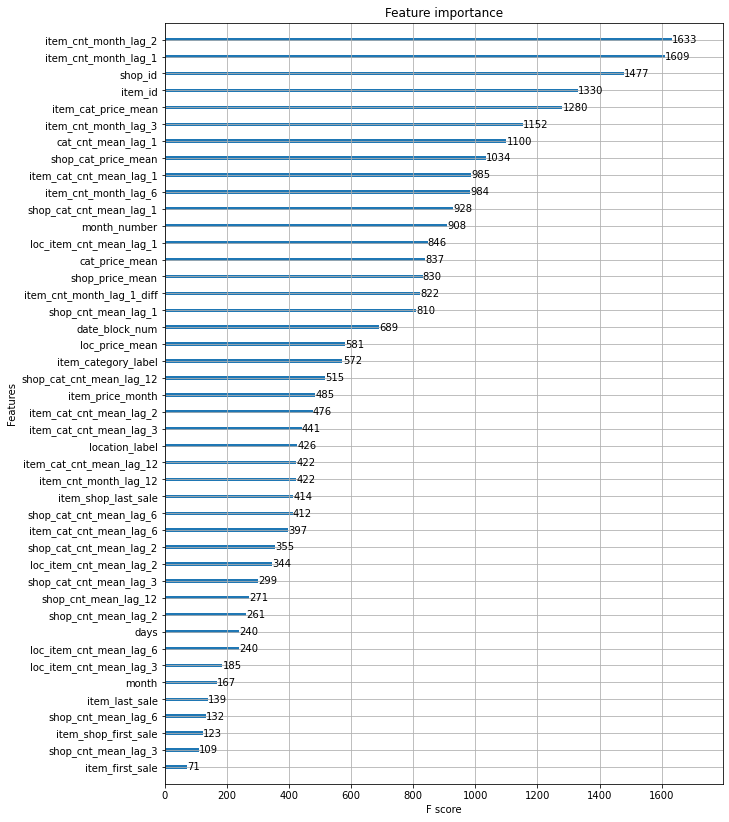

In [166]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(mdl, (10,14))

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9429604 entries, 12 to 14456187
Data columns (total 46 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    float64
 1   item_id                    float64
 2   date_block_num             int64  
 3   item_cnt_month             float64
 4   item_price_month           float64
 5   location_label             int64  
 6   item_category_label        int64  
 7   month_number               int64  
 8   month                      int64  
 9   days                       int8   
 10  item_shop_last_sale        int64  
 11  item_last_sale             int64  
 12  item_shop_first_sale       int64  
 13  item_first_sale            int64  
 14  loc_price_mean             float64
 15  loc_item_cnt_mean_lag_1    float64
 16  loc_item_cnt_mean_lag_2    float64
 17  loc_item_cnt_mean_lag_3    float64
 18  loc_item_cnt_mean_lag_6    float64
 19  loc_item_cnt_mean_lag_12   float64
 20  

<AxesSubplot:>

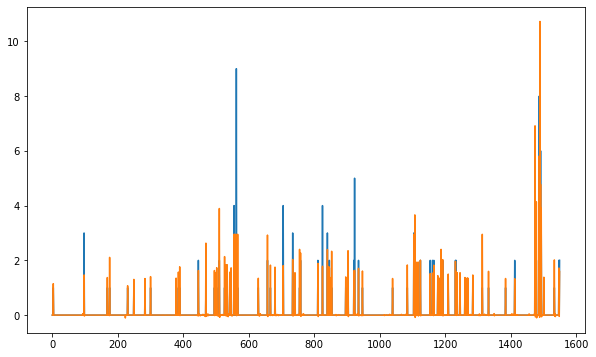

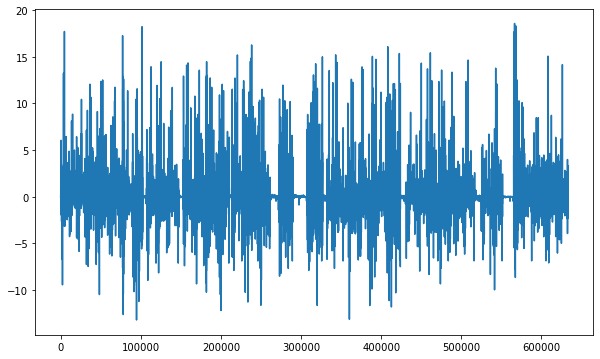

In [150]:
fig3, ax3 = plt.subplots(1,figsize=(10,6))
sns.lineplot(ax=ax3, x=np.arange(len(p[0:1550])), y=yts[0:1550])
sns.lineplot(ax=ax3, x=np.arange(len(p[0:1550])), y=p[0:1550])
fig4, ax4 = plt.subplots(1,figsize=(10,6))
res=yts-p
sns.lineplot(ax=ax4, x=np.arange(len(p)), y=res)

(array([2.3000e+01, 9.9000e+01, 5.0500e+02, 6.8500e+03, 6.2445e+05,
        7.5100e+02, 2.0700e+02, 1.2200e+02, 6.3000e+01, 1.2000e+01]),
 array([-13.21877575, -10.0386035 ,  -6.85843124,  -3.67825899,
         -0.49808674,   2.68208551,   5.86225777,   9.04243002,
         12.22260227,  15.40277452,  18.58294678]),
 <BarContainer object of 10 artists>)

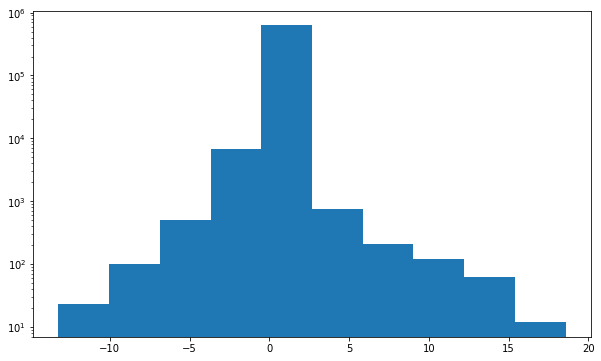

In [151]:
fig5, ax5 = plt.subplots(1,figsize=(10,6))
# sns.histplot(ax=ax5, data=np.abs(res), log_scale=True)
ax5.hist(res, log=True)

In [152]:
df[df['date_block_num'] == 34]

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,location_label,item_category_label,month_number,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,loc_price_mean,loc_item_cnt_mean_lag_1,loc_item_cnt_mean_lag_2,loc_item_cnt_mean_lag_3,loc_item_cnt_mean_lag_6,loc_item_cnt_mean_lag_12,item_cat_price_mean,item_cat_cnt_mean_lag_1,item_cat_cnt_mean_lag_2,item_cat_cnt_mean_lag_3,item_cat_cnt_mean_lag_6,item_cat_cnt_mean_lag_12,shop_cat_price_mean,shop_cat_cnt_mean_lag_1,shop_cat_cnt_mean_lag_2,shop_cat_cnt_mean_lag_3,shop_cat_cnt_mean_lag_6,shop_cat_cnt_mean_lag_12,shop_price_mean,shop_cnt_mean_lag_1,shop_cnt_mean_lag_2,shop_cnt_mean_lag_3,shop_cnt_mean_lag_6,shop_cnt_mean_lag_12,cat_price_mean,cat_cnt_mean_lag_1,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_lag_1_diff
68,2.0,30.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,2.0,31.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
138,2.0,32.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
173,2.0,33.0,34,0.0,0.0,1,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
174,2.0,38.0,34,0.0,0.0,1,7,11,10,30,-1,-1,0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14456115,59.0,22162.0,34,0.0,0.0,31,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
14456116,59.0,22163.0,34,0.0,0.0,31,7,11,10,30,-1,-1,0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14456151,59.0,22164.0,34,0.0,0.0,31,7,11,10,30,1,-1,34,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14456152,59.0,22166.0,34,0.0,0.0,31,8,11,10,30,-1,-1,0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
month = 34
test = df[df['date_block_num'] == month]
drop_clms = ['item_cnt_month']
xts = test.drop(drop_clms, axis=1)
yts = test['item_cnt_month'].values
p = mdl.predict(xts)
print(p)

[ 2.4242180e-03  3.6630575e-03  2.2087619e-03 ...  1.9964333e-05
 -6.2767089e-05  1.9964333e-05]


<AxesSubplot:>

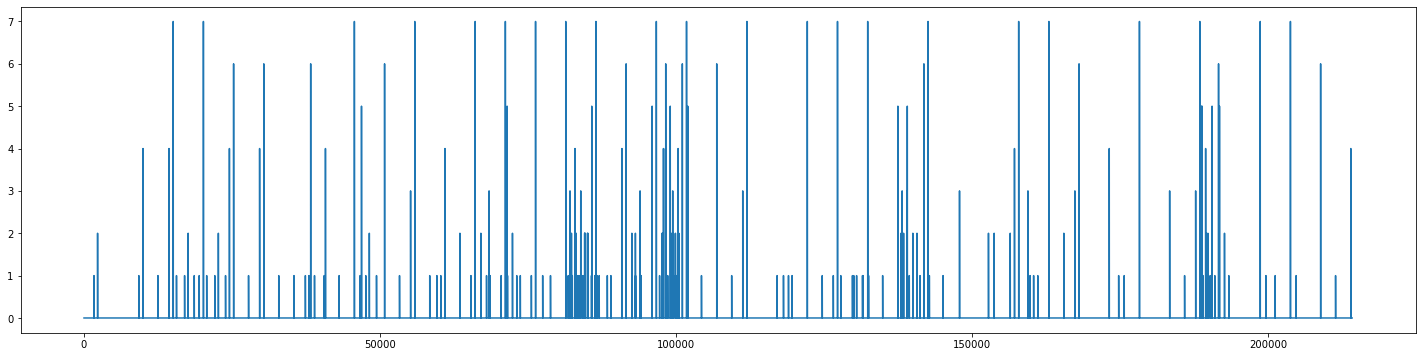

In [165]:
fig3, ax3 = plt.subplots(1,figsize=(25,6))
sns.lineplot(ax=ax3, x=np.arange(len(p)), y=preds)

In [164]:
preds = np.clip(np.rint(p), 0,20)
df_s = pd.DataFrame(preds, columns = ['item_cnt_month'])
df_s['ID'] = df_s.index
df_s = df_s.set_index('ID')
df_s.to_csv('./data/submission.csv')

In [156]:
df

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,location_label,item_category_label,month_number,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,loc_price_mean,loc_item_cnt_mean_lag_1,loc_item_cnt_mean_lag_2,loc_item_cnt_mean_lag_3,loc_item_cnt_mean_lag_6,loc_item_cnt_mean_lag_12,item_cat_price_mean,item_cat_cnt_mean_lag_1,item_cat_cnt_mean_lag_2,item_cat_cnt_mean_lag_3,item_cat_cnt_mean_lag_6,item_cat_cnt_mean_lag_12,shop_cat_price_mean,shop_cat_cnt_mean_lag_1,shop_cat_cnt_mean_lag_2,shop_cat_cnt_mean_lag_3,shop_cat_cnt_mean_lag_6,shop_cat_cnt_mean_lag_12,shop_price_mean,shop_cnt_mean_lag_1,shop_cnt_mean_lag_2,shop_cnt_mean_lag_3,shop_cnt_mean_lag_6,shop_cnt_mean_lag_12,cat_price_mean,cat_cnt_mean_lag_1,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_lag_1_diff
12,2.0,27.0,12,0.0,0.0,1,5,1,0,31,1,1,12,12,0.0,0.0,0.0,0.0,0.0,0.0,998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1231.656859,0.000000,0.000000,0.000000,0.000000,0.000000,1192.948667,0.000000,0.000000,0.000000,0.000000,0.000000,1010.209758,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
13,2.0,27.0,13,0.0,0.0,1,5,2,1,28,1,1,13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1077.371116,0.000000,0.000000,0.000000,0.000000,0.000000,1418.603419,0.000000,0.000000,0.000000,0.000000,0.000000,948.048592,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
14,2.0,27.0,14,0.0,0.0,1,5,3,2,31,1,1,14,14,0.0,0.0,0.0,0.0,0.0,0.0,998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1405.306524,0.000000,0.000000,0.000000,0.000000,0.000000,1644.622662,0.000000,0.000000,0.000000,0.000000,0.000000,1161.173326,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,27.0,15,0.0,0.0,1,5,4,3,30,1,1,15,15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1266.126716,0.000000,0.000000,0.000000,0.000000,0.000000,1379.627937,0.000000,0.000000,0.000000,0.000000,0.000000,1097.211006,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
16,2.0,27.0,16,0.0,0.0,1,5,5,4,31,1,1,16,16,0.0,0.0,0.0,0.0,0.0,0.0,498.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1239.004827,0.000000,0.000000,0.000000,0.000000,0.000000,1383.027417,0.000000,0.000000,0.000000,0.000000,0.000000,1087.023954,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14456183,59.0,22167.0,30,0.0,0.0,31,8,7,6,31,1,-1,30,30,0.0,0.0,0.0,0.0,0.0,0.0,299.000000,1.096774,1.096774,1.096774,1.096774,1.096774,908.125000,1.000000,1.000000,1.000000,1.000000,1.000000,879.240879,1.096703,1.096703,1.096703,1.096703,1.096703,542.293298,1.093652,0.0,0.0,0.0,0.0,0.0,0.0
14456184,59.0,22167.0,31,0.0,0.0,31,8,8,7,31,1,-1,31,31,0.0,0.0,0.0,0.0,0.0,0.0,299.000000,1.208333,1.208333,1.208333,1.208333,1.208333,697.142857,1.000000,1.000000,1.000000,1.000000,1.000000,845.981191,1.252317,1.252317,1.252317,1.252317,1.252317,546.452909,1.075591,0.0,0.0,0.0,0.0,0.0,0.0
14456185,59.0,22167.0,32,0.0,0.0,31,8,9,8,30,1,-1,32,32,0.0,0.0,0.0,0.0,0.0,0.0,299.000000,1.050000,1.050000,1.050000,1.050000,1.050000,585.833333,1.083333,1.083333,1.083333,1.083333,1.083333,1131.237759,1.177606,1.177606,1.177606,1.177606,1.177606,583.800837,1.127391,0.0,0.0,0.0,0.0,0.0,0.0
14456186,59.0,22167.0,33,0.0,0.0,31,8,10,9,31,1,-1,33,33,0.0,0.0,0.0,0.0,0.0,0.0,293.098437,1.156250,1.156250,1.156250,1.156250,1.156250,650.090909,1.000000,1.000000,1.000000,1.000000,1.000000,1129.378562,1.089409,1.089409,1.089409,1.089409,1.089409,549.081925,1.352578,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
# hyper_params = {    
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }



# mean_error = []
# for month in range(28,33):
#     train = df[df['date_block_num'] < month]
#     val = df[df['date_block_num'] == month]
    
#     drop_clms = ['item_cnt_month']
#     xtr, xts = train.drop(drop_clms, axis=1), val.drop(drop_clms, axis=1)
#     ytr, yts = train['item_cnt_month'].values, val['item_cnt_month'].values

#     mdl = lgb.LGBMRegressor(**hyper_params)
#     mdl.fit(xtr, ytr,
#             eval_set=[(xts, yts)],
#             eval_metric='rmse',
#             early_stopping_rounds=50)
    
# #     mdl = gbm(n_estimators=256, learning_rate=0.01)
# #     mdl.fit(xtr, np.log1p(ytr))
#     y_pred = mdl.predict(xtr, num_iteration=mdl.best_iteration_)    
    
#     p = mdl.predict(xts, num_iteration=mdl.best_iteration_)

# #     error = rmse(yts, np.expm1(p))
#     error = rmse(yts, p)
#     print('Month %d - Error %.5f' % (month, error))
#     mean_error.append(error)
# print('Mean Error = %.5f' % np.mean(mean_error))

In [158]:
# importances = mdl.feature_importances_
# # std = np.std([
# #     tree.feature_importances_ for tree in mdl.estimators_], axis=0)
# forest_importances = pd.Series(importances, index=df.drop(['item_cnt_month'], axis=1).columns)
# fig1, ax1 = plt.subplots()
# forest_importances.plot.bar(ax=ax1)
# ax1.set_title("Feature importances using MDI")
# ax1.set_ylabel("Mean decrease in impurity")
# fig1.tight_layout()
# # plt.show()

In [159]:
#add prediction = np.expm1(model.predict(test.values))

In [160]:
# mean_error = []
# for month in range(28,33):
#     train = df[df['date_block_num'] < month]
#     val = df[df['date_block_num'] == month]

#     xtr, xts = train.drop(['item_cnt_month'], axis=1), val.drop(['item_cnt_month'], axis=1)
#     ytr, yts = train['item_cnt_month'].values, val['item_cnt_month'].values

#     mdl = RandomForestRegressor(n_estimators=256, n_jobs=6, random_state=42)
#     mdl.fit(xtr, ytr)

#     p = mdl.predict(xts)

#     error = mean_absolute_percentage_error(yts, p)
#     print('Month %d - Error %.5f' % (month, error))
#     mean_error.append(error)
# print('Mean Error = %.5f' % np.mean(mean_error))



In [161]:
month = 34
test = df_g[df_g['date_block_num'] == 34]
drop_clms = ['item_cnt_month']
xts = test.drop(drop_clms, axis=1)
yts = test['item_cnt_month'].values
p = mdl.predict(xts)
error = rmse(yts, np.rint(p))
print('Month %d - Error %.5f' % (month, error))

NameError: name 'df_g' is not defined

In [ ]:
importances = mdl.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in mdl.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.drop(['month_sales'], axis=1).columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# plt.show()

In [ ]:
# A parameter grid for XGBoost
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)

X = df_g.drop(['item_cnt_month'], axis=1)
Y = df_g['item_cnt_month'].values


hyper_params = {
              'objective': 'reg:squarederror',
              'learning_rate': 0.1, #so called `eta` value
              'max_depth': 11,
              'min_child_weight': 3,
              #'verbosity ': 1,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'n_estimators': 256,
              'n_jobs' : 8
}

mdl = XGBRegressor(**hyper_params)

cv_scores = cross_val_score(mdl, X, Y, cv = tscv, scoring = 'neg_mean_squared_error')


In [ ]:
print(np.sqrt(-cv_scores))
print(np.mean(np.sqrt(-cv_scores)))